<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/Spracherkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spracherkennung

Sie haben im letzten Notebook Funktionen kennengelernt, die Audiodaten einlesen und daraus ein zeitaufgelöstes Frequenzspektrum berechnen können. Darauf aufbauend werden wir im Rahmen dieses Notebooks ein einfaches Spracherkennungssystem so programmieren, dass es Sprachaufzeichnungen verschiedener kurzer Wörter auseinander halten kann.

Dem aufmerksamen Beobachter mag aufgefallen sein, dass ein Spektrogramm im Grunde genommen ein Bild ist. Es bietet sich daher an, die Verfahren der Bilddatenanalyse, die Sie aus den frühen Teilen des Kurses kennen, auch auf Audiodaten anzuwenden.

Tatsächlich basiert ein großer Teil aktueller Techniken, bei denen Audiodaten mit neuronalen Netzen verarbeitet werden, auf diesem Prinzip. So z.B. auch die Spracherkennungsalgorithmen, die in gefühlt jedem zweiten Gerät, das einen Stecker hat, eingebaut werden, um im Hintergrund ihre Arbeit zu verrichten.

Bevor wir starten und uns einen für unser eigenes kleines Spracherkennungssystem geeigneten Datensatz organisieren, importieren wir initial wie immer einige hilfreiche Python-Werkzeuge.

In [1]:
# general imports
import glob
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
# audio-related imports
from IPython.display import Audio
import librosa
import librosa.display
from scipy.io import wavfile # kann nur wav, ist aber zig mal schneller als librosa.load

### Der Datensatz

Vor einiger Zeit hat Google einen [Datensatz](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) bereitgestellt, der es ermöglichen soll, ohne große technische Hürden mit Spracherkennungssystemen zu experimentieren. Er besteht aus ca. 65.000 einsekündigen Aufnahmen von 30 verschiedenen kurzen Sprachbefehlen, wie sie zum Beispiel bei Sprachsteurungssystemen zum Einsatz kommen. Die Aufnahmen stammen von vielen verschiedenen Sprechern und wurden unter unterschiedlichen Bedingungen erstellt, so dass sie repräsentativ genug für einen allgemeinen Einsatzzweck sind.

Um den Datensatz herunterzuladen und zu entpacken, verwenden wir wieder die entsprechenden Konsolenbefehle.

**Anmerkung**

Dieses Notebook ist darauf ausgelegt, dass die Daten sowie das Modell nur vorrübergehend im Speicher der virtuellen Maschine abgelegt werden. Möchten Sie Daten und/oder Modell längerfristig abspeichern, müssten Sie Ihr Google Drive einbinden und die Pfade entsprechend anpassen. Der Datensatz nimmt entpackt allerdings 2GB Speicher ein.

In [2]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2023-06-17 11:40:58--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.118.128, 2404:6800:4003:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.118.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  55.4MB/s    in 43s     

2023-06-17 11:41:42 (33.1 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [3]:
!ls

sample_data  speech_commands_v0.01.tar.gz


Mit den folgenden Befehlen wird der Inhalt der Datei `speech_commands_v0.01.tar.gz` in ein zuvor erstelltes Verzeichnis entpackt.

In [4]:
!mkdir speech_commands
!tar -C speech_commands -xzf speech_commands_v0.01.tar.gz

Dabei werden eine Reihe von Unterordnern erstellt, ...

In [5]:
!ls speech_commands

_background_noise_  five     marvin	right		  tree
bed		    four     nine	seven		  two
bird		    go	     no		sheila		  up
cat		    happy    off	six		  validation_list.txt
dog		    house    on		stop		  wow
down		    left     one	testing_list.txt  yes
eight		    LICENSE  README.md	three		  zero


... in denen sich eine Vielzahl an Audiodateien befinden.

In [6]:
!ls speech_commands/bed

00176480_nohash_0.wav  5e3dde6b_nohash_0.wav  b087aa0e_nohash_0.wav
004ae714_nohash_0.wav  5efb758c_nohash_0.wav  b0bad4a9_nohash_0.wav
004ae714_nohash_1.wav  5f1b1051_nohash_0.wav  b0c0197e_nohash_0.wav
00f0204f_nohash_0.wav  5f47fdf9_nohash_0.wav  b0c0197e_nohash_1.wav
00f0204f_nohash_1.wav  5f8e50a0_nohash_0.wav  b0f24c9b_nohash_0.wav
012c8314_nohash_0.wav  5f8e50a0_nohash_1.wav  b0f24c9b_nohash_1.wav
012c8314_nohash_1.wav  5fadb538_nohash_0.wav  b1114e4f_nohash_0.wav
0132a06d_nohash_0.wav  5fb88f4c_nohash_0.wav  b12bef84_nohash_0.wav
0135f3f2_nohash_0.wav  5ff3f9a1_nohash_0.wav  b12bef84_nohash_1.wav
0137b3f4_nohash_0.wav  6021f08b_nohash_0.wav  b12bef84_nohash_2.wav
014f9f65_nohash_0.wav  6021f08b_nohash_1.wav  b1426003_nohash_0.wav
01648c51_nohash_0.wav  60472d26_nohash_0.wav  b15fc37d_nohash_0.wav
01648c51_nohash_1.wav  60472d26_nohash_1.wav  b16f2d0d_nohash_0.wav
016e2c6d_nohash_0.wav  60472d26_nohash_2.wav  b1df80c0_nohash_0.wav
01b4757a_nohash_0.wav  605ed0ff_nohash_0.wav  b1

Wir haben nun also eine Ordnerstruktur und darin die `.wav`-Dateien der einzelnen kurzen Sprachaufzeichnungen. Weiterhin gibt es Textdateien mit Listen für Validierungs- und Testsets, damit die Klassifikationsergebnisse verschiedener Methoden/Modelle untereinander verglichen werden können.

Wir verwenden zunächst nur die Audiodateien. Mit `glob` können wir uns eine Liste aller `.wav`-Dateien erstellen lassen.

In [7]:
wav_files = glob.glob('speech_commands/*/*.wav')
print(len(wav_files), wav_files)

64727 ['speech_commands/down/6ac35824_nohash_0.wav', 'speech_commands/down/210f3aa9_nohash_0.wav', 'speech_commands/down/a8cf01bc_nohash_0.wav', 'speech_commands/down/46114b4e_nohash_0.wav', 'speech_commands/down/9c06a3f3_nohash_0.wav', 'speech_commands/down/de6eb27c_nohash_0.wav', 'speech_commands/down/dea820ce_nohash_4.wav', 'speech_commands/down/126a31d2_nohash_2.wav', 'speech_commands/down/692a88e6_nohash_0.wav', 'speech_commands/down/13d7b8c9_nohash_0.wav', 'speech_commands/down/fce96bac_nohash_0.wav', 'speech_commands/down/23abe1c9_nohash_2.wav', 'speech_commands/down/d1d3e64d_nohash_0.wav', 'speech_commands/down/a4b21cbc_nohash_0.wav', 'speech_commands/down/a42a88ff_nohash_0.wav', 'speech_commands/down/651d108f_nohash_0.wav', 'speech_commands/down/ce7a8e92_nohash_0.wav', 'speech_commands/down/bdee441c_nohash_0.wav', 'speech_commands/down/b59fe16d_nohash_0.wav', 'speech_commands/down/a4baac4e_nohash_0.wav', 'speech_commands/down/dbb40d24_nohash_3.wav', 'speech_commands/down/76e53

Aus dieser Liste extrahieren wir nun die Ordnernamen und damit die vorhandenen Wörter.

In [8]:
all_words = [wav_file.split('/')[1] for wav_file in wav_files]
all_words = list(set(all_words)) # unique list
print('Anzahl unterschiedlicher Klassen:', len(all_words))
pprint(all_words, compact = True)

Anzahl unterschiedlicher Klassen: 31
['five', 'bed', 'wow', 'go', 'seven', 'no', 'eight', 'marvin', 'happy', 'on',
 'zero', 'right', 'six', 'four', 'off', 'one', 'tree', 'two', 'bird', 'cat',
 'stop', 'yes', 'nine', 'up', '_background_noise_', 'dog', 'house', 'left',
 'down', 'three', 'sheila']


Die Dateien mit Hintergrundgeräuschen benötigen wir nicht.

In [9]:
all_words.remove('_background_noise_')
print('Anzahl unterschiedlicher Klassen:', len(all_words))
pprint(all_words, compact = True)

Anzahl unterschiedlicher Klassen: 30
['five', 'bed', 'wow', 'go', 'seven', 'no', 'eight', 'marvin', 'happy', 'on',
 'zero', 'right', 'six', 'four', 'off', 'one', 'tree', 'two', 'bird', 'cat',
 'stop', 'yes', 'nine', 'up', 'dog', 'house', 'left', 'down', 'three',
 'sheila']


Wir können uns ein paar zufällig gewählte Beispiele anhören.

In [10]:
# Ein zufälliges Beispiel anhören
np.random.shuffle(wav_files)
rand_file = wav_files[0]
wave,sr = librosa.load(rand_file)
print(rand_file)
Audio(wave,rate = sr)

speech_commands/no/0b77ee66_nohash_0.wav


Im Folgenden soll ein System entwickelt werden, das in der Lage ist die einzelnen Audiodaten ihren jeweiligen Wörtern (Klassen) korrekt zuordnen zu können. Allerdings werden wir die Größe des Problems reduzieren und wählen dafür lediglich zehn unterschiedliche Klassen zufällig aus.

In [11]:
N_words = 10   # Anzahl der Klassen (Wörter)
inds = np.random.permutation(range(len(all_words)))[:N_words] # N_words zufällige Indizes auswählen ...
words = np.array(all_words)[inds]  # ... und damit die entsprechenden Klassen raussuchen lassen.
# Liste aller zugehörigen Dateien anlegen
word_files = []
for f in wav_files:
    word = f.split('/')[1]
    if word in words:
        word_files.append(f)
print(len(word_files), words)

21162 ['cat' 'happy' 'on' 'off' 'two' 'yes' 'sheila' 'house' 'one' 'down']


Im nächsten Code-Block verwenden wir sogenannte Dict-Comprehensions, um hilfreiche mappings zwischen Index und Wörtern (in beide Richtungen) zu erstellen.

In [12]:
target_inds = {w:i for (i, w) in  enumerate(words)}
target_words = {i:w for (i, w) in  enumerate(words)}

### Erzeugen der Features

Wie bereits erwähnt können die Spektrogramme von Audiodaten verwendet werden, um mit Hilfe von Verfahren der Bilderkennung die für eine Klassifizierung entscheidenden Merkmale der Spektrogramm-Bilddaten zu identifizieren. Für diese Art der Klassifikationsaufgabe eignen sich insbesondere die im letzten Notebook beschriebenen Mel-Spektrogramme, da sie bereits viele relevante Merkmale (Features) menschlicher Sprache exponieren. Entsprechend müssen wir zunächst für alle Daten die Mel-Spektrogramme berechnen lassen. Hierfür verwenden wir die folgenden Parameter:

In [13]:
# Parameter für die Mel-Spektrogramme
N = len(word_files) # Maximale Anzahl an Dateien.
n_fft = 1024
hop_length = 512
n_mels = 64
fmin = 50
fmax = 5000

Jetzt können wir in einer Schleife aus allen Audiodaten der ausgewählten `N_words` Wörter Mel-Spektrogramme errechnen lassen.

In [14]:
features = []
targets = []
feature_files = [] # ursprüngliche Zuordnung behalten

for i, fname in enumerate(word_files[:N]):
    if i%100 == 0:
        print(f'\r processing file {i} of {N}', end = '')
    # WESENTLICH schneller als librosa.load
    sr, wave = wavfile.read(fname)
    # Konvertierung von int16 zu float im Wertebereich [0,1]
    wave = wave/np.iinfo(wave.dtype).max
    # Vereinheitlichung der Länge auf 1s (für eine einheitliche der Bildgröße)
    if len(wave) < sr:
        # zu kurz: Auffüllen mit Nullen
        new_wave = np.zeros((sr,))
        new_wave[:len(wave)] = wave
        wave = new_wave
    if len(wave) > sr:
        # zu lang: Abschneiden
        wave = wave[:sr]
    # Berechnung des Mel-Spektrogramms
    melspec = librosa.feature.melspectrogram(y = wave, sr=sr, n_fft=n_fft,
                                             hop_length=hop_length, fmin=fmin,
                                             fmax=fmax, n_mels=n_mels)
    # Umrechnung in logarithmierte Absolutwerte
    logspec = librosa.power_to_db(abs(melspec))

    features.append(logspec.T)
    word = fname.split('/')[1]
    targets.append(target_inds[word])
    feature_files.append(fname)

 processing file 21100 of 21162

Zur Kontrolle werfen wir einen Blick auf ein paar zufällig ausgewählte Spektrogramme.

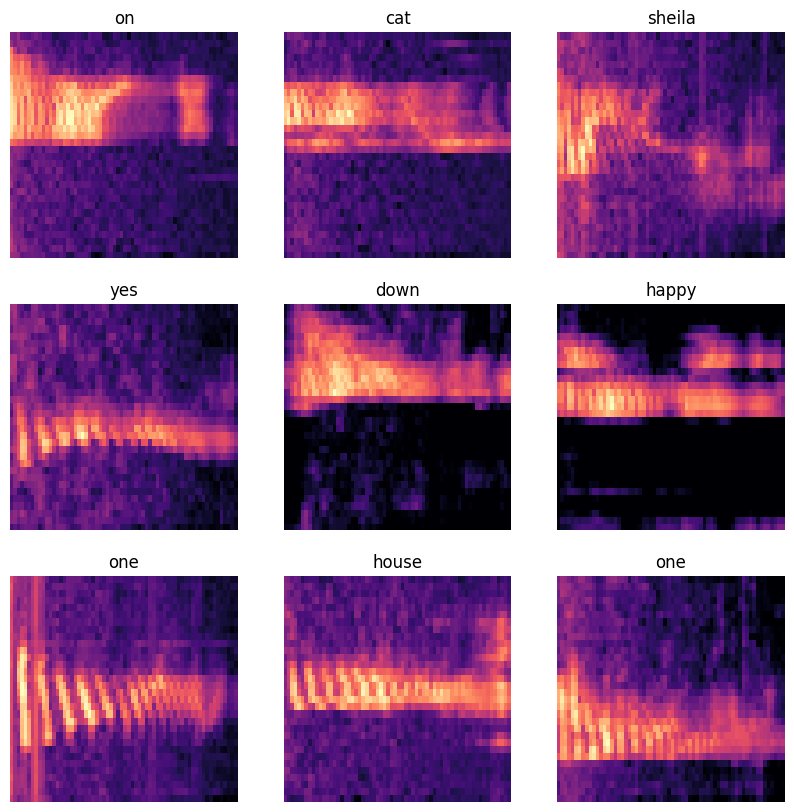

In [15]:
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    rand_ind = np.random.randint(N)
    log_spec = features[rand_ind]
    word = target_words[targets[rand_ind]]
    plt.title(word)
    plt.pcolor(log_spec,cmap = 'magma')
    plt.axis('off')

Für die Unterteilung in Trainings- und Testdaten wandeln wir die erzeugten Listen zunächst in numpy arrays um.

In [16]:
features = np.array(features)
targets = np.array(targets)
feature_files = np.array(feature_files)

Anschließend können wir die Daten mit wenig Aufwand in Trainings- und Testdaten unterteilen, da der Datentyp `ndarray` im Vergleich zu herkömmlichen Listen mehr Möglichkeiten für die Indizierung von Elementen bietet.

In [17]:
all_inds = list(range(features.shape[0]))
np.random.shuffle(all_inds)
train_ratio = 0.7
first_test_index = int(train_ratio * len(all_inds))
train_inds = all_inds[:first_test_index]
test_inds = all_inds[first_test_index:]
# Trainingsdaten
train_features = features[train_inds]
train_targets = targets[train_inds]
train_files = feature_files[train_inds]
print('Trainingsdaten:', train_features.shape)
# Testdaten
test_features = features[test_inds]
test_targets = targets[test_inds]
test_files = feature_files[test_inds]
print('Testedaten:', test_features.shape)

Trainingsdaten: (14813, 32, 64)
Testedaten: (6349, 32, 64)


### Modelldefinition

Wir verwenden das Paket `Keras`, das mit einfacher Syntax die Erstellung komplexer Netze erlaubt, um ein Faltungsnetz (convolutional neural network) zu erstellen, mit Hilfe dessen wir die Klassifikationsaufgabe zu lösen versuchen.

In [19]:
import keras
from keras import layers
from keras.models import Sequential
from sklearn.metrics import confusion_matrix # sklearn is a popular machine learning library

Im Unterschied zu den Netzen, die man für die Klassifikation von Bilddaten verwenden würde, setzen wir hier zunächst lediglich eine eindimensionale Faltungsoperation ein. Dies hat den Grund, dass die Mel-Spektren bereits nahezu frequenzinvariant sind, da die Tonhöhe der Sprache aus den urspünglichen Daten dabei herausgerechnet wird. Mit anderen Worten sollten sich die Mel-Spektren von zwei Sprechern, die die gleichen Wörter in unterschiedlichen Stimmlagen aussprechen, weitgehen ähneln.

Als Folge der eindimensionalen Faltung nimmt ein Kernel der Größe (Breite) *3* automatisch die Höhe des gesamten Spektrums an und wird im Rahmen der Faltungsoperation in Richtung der Zeit über das *Bild* geschoben (und mit den jeweiligen Werten multipliziert).

Wie bei Klassifikationsaufgaben üblich wird als Aktivierungsfunktion der units in der Ausgabeschicht die `softmax`-Funktion verwendet.

In [20]:
model = Sequential()
model.add(layers.Conv1D(32, kernel_size=3, strides=1, input_shape=train_features.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(64, kernel_size=3, strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(N_words, activation='softmax'))
model.compile(
    loss='sparse_categorical_crossentropy',  # Klassifizierungsfehler
    metrics=['accuracy'],
    optimizer='adam',
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            6176      
                                                                 
 batch_normalization (BatchN  (None, 30, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 64)           256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 14, 64)            0

Das Modell kann nun trainiert werden.

In [22]:
model.fit(train_features,
          train_targets,
          validation_data = (test_features,test_targets),
          epochs = 20)

Epoch 1/20
463/463 [==============================] - 17s 8ms/step - loss: 1.2278 - accuracy: 0.5872 - val_loss: 0.8710 - val_accuracy: 0.7267
Epoch 2/20
463/463 [==============================] - 3s 7ms/step - loss: 0.6546 - accuracy: 0.7938 - val_loss: 0.6082 - val_accuracy: 0.8171
Epoch 3/20
463/463 [==============================] - 3s 6ms/step - loss: 0.4769 - accuracy: 0.8499 - val_loss: 0.4494 - val_accuracy: 0.8696
Epoch 4/20
463/463 [==============================] - 4s 9ms/step - loss: 0.3959 - accuracy: 0.8759 - val_loss: 0.5702 - val_accuracy: 0.8181
Epoch 5/20
463/463 [==============================] - 6s 13ms/step - loss: 0.3414 - accuracy: 0.8937 - val_loss: 1.3191 - val_accuracy: 0.6499
Epoch 6/20
463/463 [==============================] - 3s 7ms/step - loss: 0.2950 - accuracy: 0.9099 - val_loss: 0.3763 - val_accuracy: 0.8871
Epoch 7/20
463/463 [==============================] - 3s 7ms/step - loss: 0.2667 - accuracy: 0.9151 - val_loss: 0.5499 - val_accuracy: 0.8365
Epoc

### Auswertung der Ergebnisse

Mit diesem einfachen Modell erzielen wir schon recht gute Ergebnisse. Wir können uns einige falsch klassifizierte Beispiele der Testdaten anhören. Hierfür berechnen wir zunächst die Vorhersagen für sämtliche Testdaten und wählen dann aus allen falschen Vorhersagen eine zufällig aus.

In [26]:
test_predictions = np.argmax(model.predict(test_features),axis=1)
wrong_predictions = np.where(test_predictions!=test_targets)[0]

199/199 [==============================] - 1s 3ms/step


In [27]:
rand_prediction = np.random.permutation(wrong_predictions)[0]
actual_word = target_words[test_targets[rand_prediction]]
predicted_word = target_words[test_predictions[rand_prediction]]
print('Zugehörige Klasse:', actual_word, '\t Vorhergesagte Klasse:', predicted_word)
wave,sr = librosa.load(test_files[rand_prediction])
Audio(wave,rate = sr)

Zugehörige Klasse: down 	 Vorhergesagte Klasse: one


Ein nützliches Werkzeug zum Beurteilen von Klassifikationsergebnissen ist die [Confusion-Matrix](https://en.wikipedia.org/wiki/Confusion_matrix). In dieser wird dargestellt, welche Vorhersage wie oft für welche Klasse getroffen wurde.
Die Funktion zur Berechnung der Matrix können wir der Bibliothek [`sklearn`](https://scikit-learn.org/stable/) entnehmen.

---

**Anmerkung**

`sklearn` ist die populärste Python-Bibliothek für klassisches Machine-Learning und beinhaltet entsprechend viele nützliche Funktionen.

In [28]:
conf_mat = confusion_matrix(test_targets,test_predictions)

Die Darstellung der Confusion-Matrix ist leider etwas umständlich und muss nicht im Detail verstanden werden.

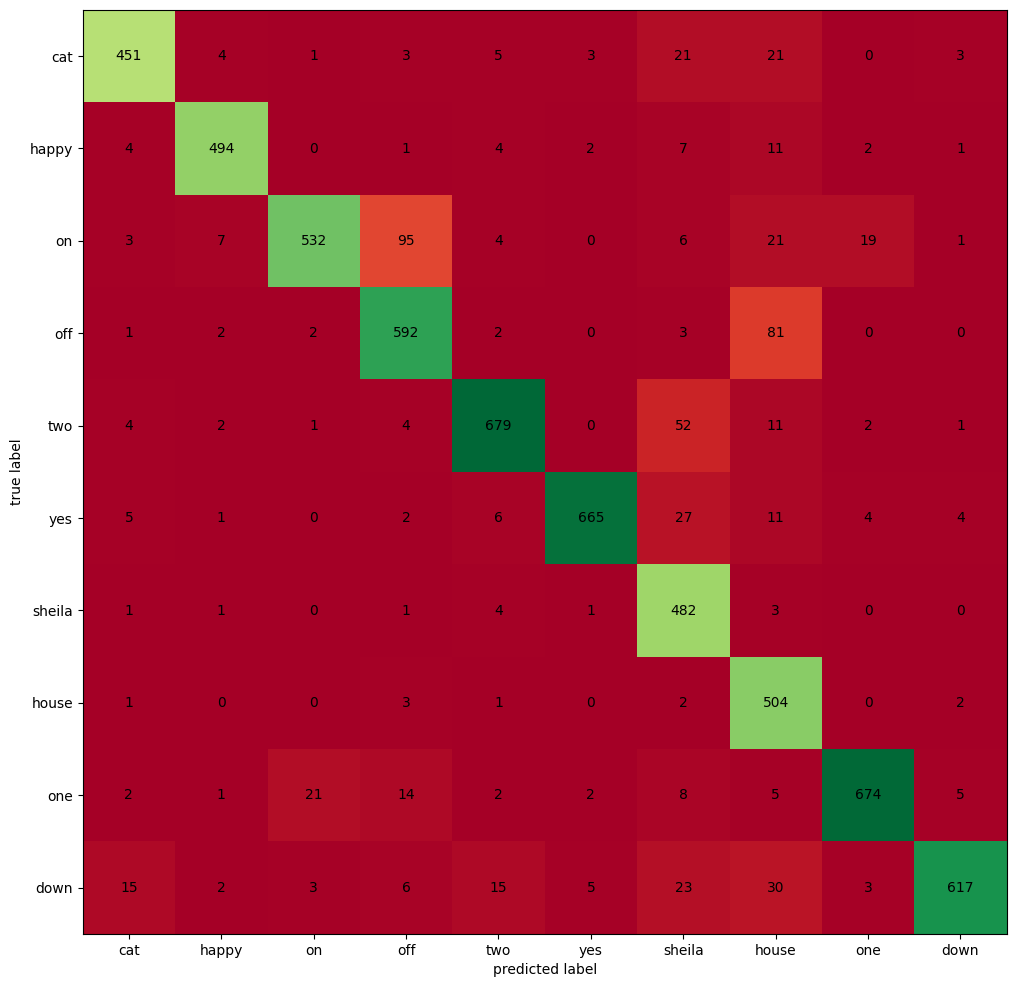

In [29]:
plt.figure(figsize = (12,12))
plt.imshow(conf_mat, cmap='RdYlGn')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_labels = [target_words[c] for c in np.unique(test_targets)]
plt.yticks(np.arange(N_words), tick_labels)
plt.xticks(np.arange(N_words), tick_labels)

for i in range(N_words):
    for j in range(N_words):
        plt.text(i, j, conf_mat[j, i], va='center', ha='center', color='k')

Nehmen Sie sich etwas Zeit, um sich die Ergebniss etwas näher anzuschauen. Bei ähnlich klingenden Wörtern dürften falsche Zuordnungen am häufigsten vorkommen. Auch die Anzahl der Beispiele pro Klasse und die durschnittliche Aufzeichnungsqualität der zugehörigen Samples haben einen Einfluss.